In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker

from misc import get_neptune_table, get_activations, plot_module


In [2]:
tags = ['relativity_paper', 'medium_model', 'std']


df = get_neptune_table(tags)
print(df.shape)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (12, 416)
(12, 416)


In [4]:
act_dict = get_activations(df, 'mean')
print(act_dict)

run ID: LLMRANDOM-16160
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16160
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 8
run ID: LLMRANDOM-16159
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16159
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 8
run ID: LLMRANDOM-16158
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16158
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 8
run ID: LLMRANDOM-16157
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16157
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 8
run ID: LLMRANDOM-16156
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16156
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 8
run ID: LLMRANDOM-16155
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-16155
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 8
run ID: LLMRANDOM-16120
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM

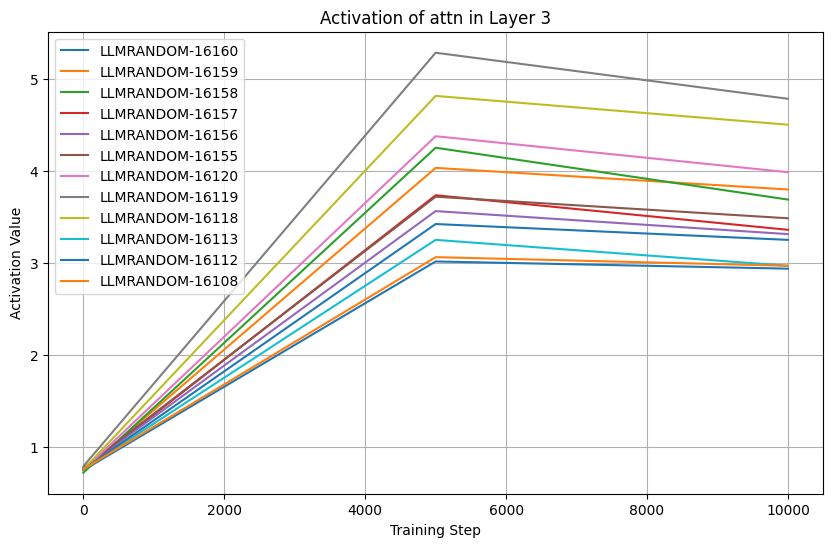

In [5]:
plot_module(
    values_dict=act_dict,
    module_keyword='attn',
    layer_num=3,
)